# Functional Encryption - Classification and information leakage
 

### Purpose

This a special case where we do a long sabotage phase to resist to long terms attack from distinguisher.

## 1. Parameters and imports


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
torch.set_num_threads(4)

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 50
        self.new_adversary_epochs = 50
        self.distinguisher_epochs = 50
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Some utility functions

In [5]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets():
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    return train_dataset, test_dataset

def get_data_loaders():
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets()

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

## 2. Building resistance

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [6]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [7]:
import torch

In [8]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Phase 1
        if initial_phase: # Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        elif perturbate: # Optimise Freezed(Q) + C
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 2
        if (initial_phase or perturbate): # Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
        elif new_collateral: # Optimise Freezed(Q) + new F
            model.freeze('quad')
            optimizer.zero_grad()
            output_font = model.forward_adv_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 3
        if perturbate: # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
            
            
        if new_collateral:
            loss_char = torch.zeros(1)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [9]:
def test(args, model, test_loader, new_adversary):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            if not new_adversary:
                output = model.forward_char(data)
                pred = output.argmax(1, keepdim=True)
                correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not new_adversary:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [10]:
def build_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        new_adversary = False
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [11]:
path = '../data/models/quadconvnet_part19bis.pt'
model = QuadConvNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.5
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Computing model...
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.330634 Loss Font: 1.608884
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.267047 Loss Font: 1.607864
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.197417 Loss Font: 1.617026
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.098466 Loss Font: 1.593278
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.980423 Loss Font: 1.578412
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.462288 Loss Font: 1.568220
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.212502 Loss Font: 1.447614
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.162196 Loss Font: 1.552814
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.867889 Loss Font: 1.614768
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.878750 Loss Font: 1.559753

Test set: Accuracy Char : 4737/10000 (47.37%)
          Accuracy Font : 2911/10000 (29.11%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.540739 Loss Font: 1

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.294276 Loss Font: 0.934732
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.154808 Loss Font: 0.665239
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.362734 Loss Font: 0.673049
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.334195 Loss Font: 0.869533

Test set: Accuracy Char : 9217/10000 (92.17%)
          Accuracy Font : 6405/10000 (64.05%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.200388 Loss Font: 0.850175
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.285624 Loss Font: 1.241684
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.280752 Loss Font: 1.424358
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.180067 Loss Font: 1.369035
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.293359 Loss Font: 1.479321
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.255863 Loss Font: 1.402171
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.363419 Loss Font: 1.488118
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.316887 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.099025 Loss Font: 1.484155
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.272515 Loss Font: 1.505472
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.084700 Loss Font: 1.514985
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.083991 Loss Font: 1.494980
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.073552 Loss Font: 1.583822
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.240961 Loss Font: 1.512992
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.146359 Loss Font: 1.568953
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.111879 Loss Font: 1.492852
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.135639 Loss Font: 1.481211

Test set: Accuracy Char : 8770/10000 (87.70%)
          Accuracy Font : 2852/10000 (28.52%)
(perturbate)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.297935 Loss Font: 1.534499
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.229081 Loss Font: 1.494128
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.306279 Loss Font

Train Epoch: 29 [44800/60000 (75%)]	Loss Char: 0.148524 Loss Font: 1.519299
Train Epoch: 29 [51200/60000 (85%)]	Loss Char: 0.275120 Loss Font: 1.521852
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.172483 Loss Font: 1.531028

Test set: Accuracy Char : 9089/10000 (90.89%)
          Accuracy Font : 3095/10000 (30.95%)
(perturbate)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.163285 Loss Font: 1.544031
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.248715 Loss Font: 1.488176
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.185216 Loss Font: 1.531763
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.276982 Loss Font: 1.433735
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.119853 Loss Font: 1.474741
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.108114 Loss Font: 1.515188
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.159487 Loss Font: 1.502765
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.172535 Loss Font: 1.477062
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.163847 Loss Fon

Train Epoch: 39 [12800/60000 (21%)]	Loss Char: 0.166219 Loss Font: 1.489045
Train Epoch: 39 [19200/60000 (32%)]	Loss Char: 0.151135 Loss Font: 1.517961
Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.235131 Loss Font: 1.548640
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.163329 Loss Font: 1.503258
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.314475 Loss Font: 1.532405
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.151245 Loss Font: 1.535570
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.121993 Loss Font: 1.436111
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.371042 Loss Font: 1.497357

Test set: Accuracy Char : 8986/10000 (89.86%)
          Accuracy Font : 3098/10000 (30.98%)
(perturbate)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.181724 Loss Font: 1.579044
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.173173 Loss Font: 1.496608
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.254921 Loss Font: 1.490131
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.194850 Loss Fon

Train Epoch: 48 [51200/60000 (85%)]	Loss Char: 0.177662 Loss Font: 1.454365
Train Epoch: 48 [57600/60000 (96%)]	Loss Char: 0.164947 Loss Font: 1.529349

Test set: Accuracy Char : 8982/10000 (89.82%)
          Accuracy Font : 3050/10000 (30.50%)
(perturbate)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.137387 Loss Font: 1.518299
Train Epoch: 49 [6400/60000 (11%)]	Loss Char: 0.277250 Loss Font: 1.511353
Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.171690 Loss Font: 1.612012
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.096185 Loss Font: 1.625269
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.130887 Loss Font: 1.509618
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.301851 Loss Font: 1.462237
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.414238 Loss Font: 1.468057
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.056525 Loss Font: 1.468326
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.254017 Loss Font: 1.522462
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.091563 Loss Fon

Train Epoch: 58 [19200/60000 (32%)]	Loss Char: 0.119452 Loss Font: 1.571393
Train Epoch: 58 [25600/60000 (43%)]	Loss Char: 0.334563 Loss Font: 1.491718
Train Epoch: 58 [32000/60000 (53%)]	Loss Char: 0.080937 Loss Font: 1.489417
Train Epoch: 58 [38400/60000 (64%)]	Loss Char: 0.221481 Loss Font: 1.559011
Train Epoch: 58 [44800/60000 (75%)]	Loss Char: 0.355676 Loss Font: 1.440794
Train Epoch: 58 [51200/60000 (85%)]	Loss Char: 0.137956 Loss Font: 1.496302
Train Epoch: 58 [57600/60000 (96%)]	Loss Char: 0.288843 Loss Font: 1.507483

Test set: Accuracy Char : 8951/10000 (89.51%)
          Accuracy Font : 3129/10000 (31.29%)
(perturbate)
Train Epoch: 59 [0/60000 (0%)]	Loss Char: 0.265124 Loss Font: 1.466448
Train Epoch: 59 [6400/60000 (11%)]	Loss Char: 0.231775 Loss Font: 1.530504
Train Epoch: 59 [12800/60000 (21%)]	Loss Char: 0.182135 Loss Font: 1.460745
Train Epoch: 59 [19200/60000 (32%)]	Loss Char: 0.275401 Loss Font: 1.446134
Train Epoch: 59 [25600/60000 (43%)]	Loss Char: 0.093631 Loss Fon

# 3. Testing distinguishability

In [12]:
quadratic_model = model
quadratic_model.freeze('quad')

In [13]:
def evaluate_resistance(model, alpha=0):
    """
    Perform a learning phase for the CL model
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        new_adversary = True
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [14]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
        # --- distinguisher
        self.fc3 = nn.Linear(N_FONTS, 2)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
        
    def forward_distinguisher(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [15]:
resistance_reports = {}

## 3.1 Fully connected models 

In [16]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = 8
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

### General font detection training

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 4.558428
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.873999
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.799353
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.680372
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.623025
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.566896
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.595339
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.604170
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.674210
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.653998

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2160/10000 (21.60%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.642586
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2355/10000 (23.55%)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.621901
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.585068
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.588579
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.592432
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.573572
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.629255
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.593368
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.603200
Train Epoch: 11 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.557531
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.606041

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2442/10000 (24.42%)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.5332

Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.582420
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.561754
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.606092

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2510/10000 (25.10%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.556660
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.590480
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.594946
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.603491
Train Epoch: 21 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.561352
Train Epoch: 21 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.556369
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.618862
Train Epoch: 21 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.594799
Train Epoch: 21 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.599871
Train

Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.593399
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.587113
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.600208
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.557357
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.563025
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.591436

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2609/10000 (26.09%)
Train Epoch: 31 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.570042
Train Epoch: 31 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.603439
Train Epoch: 31 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.571286
Train Epoch: 31 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.599670
Train Epoch: 31 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.576342
Train Epoch: 31 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.635266
Train

Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.516623
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.602779
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.661056
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.594913
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.567402
Train Epoch: 40 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.561753
Train Epoch: 40 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.594542
Train Epoch: 40 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.589770

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2626/10000 (26.26%)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.623342
Train Epoch: 41 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.578820
Train Epoch: 41 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.556854
Train Epoch: 41 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.576406
Train


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2655/10000 (26.55%)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.523331
Train Epoch: 50 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.574702
Train Epoch: 50 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.580334
Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.572642
Train Epoch: 50 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.605026
Train Epoch: 50 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.584343
Train Epoch: 50 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.570126
Train Epoch: 50 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.621336
Train Epoch: 50 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.583745
Train Epoch: 50 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.600584

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2631/10000 (26.31%)


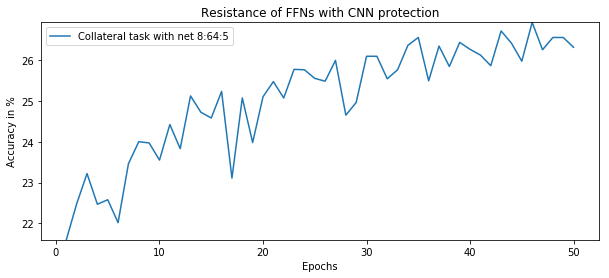

In [17]:
architectures = [[64]]

model = None 
for architecture in architectures:
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


In [18]:
train_dataset, test_dataset = get_datasets()

Training set 60000 items
Testing set  10000 items


### Distinguisher training

Let's update the dataloader and dataset building functions to filter the fonts we want to keep

In [19]:
def build_tensor_dataset_dist(data, target, fonts):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    target = [[i[0][0], i[1][0]] for i in target]
    
    normed_data_filtered, target_filtered = [], []
    for data_item, target_item in zip(normed_data, target):
        if target_item[1] in fonts:
            normed_data_filtered.append(data_item)
            target_filtered.append(target_item)
    normed_data = normed_data_filtered
    target = target_filtered
    
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor(target)
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets_dist(fonts):
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset_dist(train_data, train_target, fonts)
    test_dataset = build_tensor_dataset_dist(test_data, test_target, fonts)
    
    print(len(test_dataset))
    return train_dataset, test_dataset

def get_data_loaders_dist(fonts):
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets_dist(fonts)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

In [20]:
def train_distinguisher(args, model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target_font = target[:, 1]
        
        #target_distinguisher = torch.stack((target_font == 3, target_font == 1), dim=1).long()
        target_distinguisher = (target_font == 1).long()
        
        model.freeze('quad')
        optimizer.zero_grad()

        output_font = model.forward_distinguisher(data)
        #print(output_font)
        loss_font = F.nll_loss(output_font, target_distinguisher)

        loss_font.backward()
        optimizer.step()
        model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_font.item()))

In [21]:
def test_distinguisher(args, model, test_loader):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            target_font = target[:, 1]
        
            target_distinguisher = (target_font == 1).long()

            
            output = model.forward_distinguisher(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_distinguisher.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [22]:
def build_distinguisher(model, fonts):
    """
    Perform a learning phase for the CL model
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders_dist(fonts)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    for epoch in range(1, args.distinguisher_epochs + 1):        
        train_distinguisher(args, model, train_loader, optimizer, epoch)
        test_distinguisher(args, model, test_loader)

In [23]:
build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.709767
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.719034
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.717613
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.673160

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2106/4011 (52.51%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.675930
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.694743
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.676486
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.693532

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2166/4011 (54.00%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 0.680812
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.695670
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.692615
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.679718

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2180/4011 (54.35%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0

Train Epoch: 28 [6400/24193 (26%)]	Loss Font: 0.612506
Train Epoch: 28 [12800/24193 (53%)]	Loss Font: 0.675462
Train Epoch: 28 [19200/24193 (79%)]	Loss Font: 0.676435

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2300/4011 (57.34%)
Train Epoch: 29 [0/24193 (0%)]	Loss Font: 0.696893
Train Epoch: 29 [6400/24193 (26%)]	Loss Font: 0.625775
Train Epoch: 29 [12800/24193 (53%)]	Loss Font: 0.714465
Train Epoch: 29 [19200/24193 (79%)]	Loss Font: 0.626575

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2245/4011 (55.97%)
Train Epoch: 30 [0/24193 (0%)]	Loss Font: 0.690903
Train Epoch: 30 [6400/24193 (26%)]	Loss Font: 0.655913
Train Epoch: 30 [12800/24193 (53%)]	Loss Font: 0.694656
Train Epoch: 30 [19200/24193 (79%)]	Loss Font: 0.689685

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2212/4011 (55.15%)
Train Epoch: 31 [0/24193 (0%)]	Loss Font: 0.652336
Train Epoch: 31 [6400/24193 (26%)]	Loss Font: 0.669677
Train Epoch: 31 [12800/24193 (

### Distinguisher testing

Version ML

In [24]:
# See above

Version Crypto

In [25]:

def get_pair_distinguish(dataset, font1, font2):
    """Get two samples with same character but different font"""
    found = False
    while not found:
        idx = np.random.randint(len(dataset))
        sample1 = dataset[idx]
        labels1 = sample1[1]
        idx = np.random.randint(len(dataset))
        sample2 = dataset[idx]
        labels2 = sample2[1]
        # If same char but different font and eq to (font1, font2)
        if labels1[0] == labels2[0] and labels1[1] == font1 and labels2[1] == font2:
            return sample1, sample2
    

def test_distinguish(model, test_dataset):
    model.eval()
    n_tests = 1000
    correct_font = 0
    acc_by_class = {}
    with torch.no_grad():
        for i in range(n_tests):
            class1, class2 = 3, 1
            samples = get_pair_distinguish(test_dataset, class1, class2)
            
            beta = np.random.randint(2)
            selected_sample = samples[beta]
            
            data = selected_sample[0]
            
            output = model.forward_distinguisher(data)
            
            pred = output.argmax(1, keepdim=True)
            
            is_correct = pred.eq(torch.tensor(beta).view_as(pred)).sum().item()
            correct_font += is_correct
            
            key = f'{class1}-{class2}'

            
    print('Acc', round(100*correct_font/n_tests, 2), '%')
    


In [26]:
test_distinguish(model, test_dataset)

Acc 52.1 %


Actually you can iterate more to improve the distinguisher:

In [27]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.distinguisher_epochs = 200 # <-- NEW value
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [28]:
build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.876604
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.720848
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.674839
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.605938

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2185/4011 (54.48%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.681482
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.658737
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.670015
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.682830

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2428/4011 (60.53%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 0.635159
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.687455
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.626291
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.691278

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2349/4011 (58.56%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0

Train Epoch: 28 [12800/24193 (53%)]	Loss Font: 0.674285
Train Epoch: 28 [19200/24193 (79%)]	Loss Font: 0.654214

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2290/4011 (57.09%)
Train Epoch: 29 [0/24193 (0%)]	Loss Font: 0.703225
Train Epoch: 29 [6400/24193 (26%)]	Loss Font: 0.599733
Train Epoch: 29 [12800/24193 (53%)]	Loss Font: 0.720126
Train Epoch: 29 [19200/24193 (79%)]	Loss Font: 0.622939

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2362/4011 (58.89%)
Train Epoch: 30 [0/24193 (0%)]	Loss Font: 0.681639
Train Epoch: 30 [6400/24193 (26%)]	Loss Font: 0.596809
Train Epoch: 30 [12800/24193 (53%)]	Loss Font: 0.678733
Train Epoch: 30 [19200/24193 (79%)]	Loss Font: 0.653991

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2286/4011 (56.99%)
Train Epoch: 31 [0/24193 (0%)]	Loss Font: 0.643776
Train Epoch: 31 [6400/24193 (26%)]	Loss Font: 0.698217
Train Epoch: 31 [12800/24193 (53%)]	Loss Font: 0.649635
Train Epoch: 31 [19200/24193 


Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2469/4011 (61.56%)
Train Epoch: 56 [0/24193 (0%)]	Loss Font: 0.693216
Train Epoch: 56 [6400/24193 (26%)]	Loss Font: 0.638706
Train Epoch: 56 [12800/24193 (53%)]	Loss Font: 0.586772
Train Epoch: 56 [19200/24193 (79%)]	Loss Font: 0.631781

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2349/4011 (58.56%)
Train Epoch: 57 [0/24193 (0%)]	Loss Font: 0.760834
Train Epoch: 57 [6400/24193 (26%)]	Loss Font: 0.637098
Train Epoch: 57 [12800/24193 (53%)]	Loss Font: 0.625368
Train Epoch: 57 [19200/24193 (79%)]	Loss Font: 0.736916

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2461/4011 (61.36%)
Train Epoch: 58 [0/24193 (0%)]	Loss Font: 0.794005
Train Epoch: 58 [6400/24193 (26%)]	Loss Font: 0.619136
Train Epoch: 58 [12800/24193 (53%)]	Loss Font: 0.606364
Train Epoch: 58 [19200/24193 (79%)]	Loss Font: 0.542885

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2570/4011 (64.07%

Train Epoch: 83 [12800/24193 (53%)]	Loss Font: 0.604592
Train Epoch: 83 [19200/24193 (79%)]	Loss Font: 0.590349

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2493/4011 (62.15%)
Train Epoch: 84 [0/24193 (0%)]	Loss Font: 0.672989
Train Epoch: 84 [6400/24193 (26%)]	Loss Font: 0.656803
Train Epoch: 84 [12800/24193 (53%)]	Loss Font: 0.649224
Train Epoch: 84 [19200/24193 (79%)]	Loss Font: 0.601339

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2344/4011 (58.44%)
Train Epoch: 85 [0/24193 (0%)]	Loss Font: 0.671183
Train Epoch: 85 [6400/24193 (26%)]	Loss Font: 0.608436
Train Epoch: 85 [12800/24193 (53%)]	Loss Font: 0.656662
Train Epoch: 85 [19200/24193 (79%)]	Loss Font: 0.574828

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2467/4011 (61.51%)
Train Epoch: 86 [0/24193 (0%)]	Loss Font: 0.610525
Train Epoch: 86 [6400/24193 (26%)]	Loss Font: 0.689118
Train Epoch: 86 [12800/24193 (53%)]	Loss Font: 0.625464
Train Epoch: 86 [19200/24193 

Train Epoch: 110 [6400/24193 (26%)]	Loss Font: 0.602081
Train Epoch: 110 [12800/24193 (53%)]	Loss Font: 0.639404
Train Epoch: 110 [19200/24193 (79%)]	Loss Font: 0.634755

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2305/4011 (57.47%)
Train Epoch: 111 [0/24193 (0%)]	Loss Font: 0.740974
Train Epoch: 111 [6400/24193 (26%)]	Loss Font: 0.629590
Train Epoch: 111 [12800/24193 (53%)]	Loss Font: 0.686972
Train Epoch: 111 [19200/24193 (79%)]	Loss Font: 0.536699

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2602/4011 (64.87%)
Train Epoch: 112 [0/24193 (0%)]	Loss Font: 0.601441
Train Epoch: 112 [6400/24193 (26%)]	Loss Font: 0.571516
Train Epoch: 112 [12800/24193 (53%)]	Loss Font: 0.623451
Train Epoch: 112 [19200/24193 (79%)]	Loss Font: 0.647597

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2319/4011 (57.82%)
Train Epoch: 113 [0/24193 (0%)]	Loss Font: 0.701785
Train Epoch: 113 [6400/24193 (26%)]	Loss Font: 0.623167
Train Epoch: 113 

Train Epoch: 137 [6400/24193 (26%)]	Loss Font: 0.538707
Train Epoch: 137 [12800/24193 (53%)]	Loss Font: 0.654405
Train Epoch: 137 [19200/24193 (79%)]	Loss Font: 0.658557

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2438/4011 (60.78%)
Train Epoch: 138 [0/24193 (0%)]	Loss Font: 0.846661
Train Epoch: 138 [6400/24193 (26%)]	Loss Font: 0.628100
Train Epoch: 138 [12800/24193 (53%)]	Loss Font: 0.595830
Train Epoch: 138 [19200/24193 (79%)]	Loss Font: 0.594064

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2217/4011 (55.27%)
Train Epoch: 139 [0/24193 (0%)]	Loss Font: 0.822154
Train Epoch: 139 [6400/24193 (26%)]	Loss Font: 0.609742
Train Epoch: 139 [12800/24193 (53%)]	Loss Font: 0.653283
Train Epoch: 139 [19200/24193 (79%)]	Loss Font: 0.564534

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2577/4011 (64.25%)
Train Epoch: 140 [0/24193 (0%)]	Loss Font: 0.608911
Train Epoch: 140 [6400/24193 (26%)]	Loss Font: 0.546462
Train Epoch: 140 

Train Epoch: 164 [6400/24193 (26%)]	Loss Font: 0.645604
Train Epoch: 164 [12800/24193 (53%)]	Loss Font: 0.624917
Train Epoch: 164 [19200/24193 (79%)]	Loss Font: 0.601118

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2546/4011 (63.48%)
Train Epoch: 165 [0/24193 (0%)]	Loss Font: 0.691611
Train Epoch: 165 [6400/24193 (26%)]	Loss Font: 0.689113
Train Epoch: 165 [12800/24193 (53%)]	Loss Font: 0.627518
Train Epoch: 165 [19200/24193 (79%)]	Loss Font: 0.623640

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2441/4011 (60.86%)
Train Epoch: 166 [0/24193 (0%)]	Loss Font: 0.557687
Train Epoch: 166 [6400/24193 (26%)]	Loss Font: 0.678579
Train Epoch: 166 [12800/24193 (53%)]	Loss Font: 0.594840
Train Epoch: 166 [19200/24193 (79%)]	Loss Font: 0.581719

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2535/4011 (63.20%)
Train Epoch: 167 [0/24193 (0%)]	Loss Font: 0.703759
Train Epoch: 167 [6400/24193 (26%)]	Loss Font: 0.591685
Train Epoch: 167 


Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2465/4011 (61.46%)
Train Epoch: 191 [0/24193 (0%)]	Loss Font: 0.854443
Train Epoch: 191 [6400/24193 (26%)]	Loss Font: 0.679039
Train Epoch: 191 [12800/24193 (53%)]	Loss Font: 0.671629
Train Epoch: 191 [19200/24193 (79%)]	Loss Font: 0.574193

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2188/4011 (54.55%)
Train Epoch: 192 [0/24193 (0%)]	Loss Font: 1.180897
Train Epoch: 192 [6400/24193 (26%)]	Loss Font: 0.638326
Train Epoch: 192 [12800/24193 (53%)]	Loss Font: 0.600154
Train Epoch: 192 [19200/24193 (79%)]	Loss Font: 0.610216

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2224/4011 (55.45%)
Train Epoch: 193 [0/24193 (0%)]	Loss Font: 0.844745
Train Epoch: 193 [6400/24193 (26%)]	Loss Font: 0.695900
Train Epoch: 193 [12800/24193 (53%)]	Loss Font: 0.670814
Train Epoch: 193 [19200/24193 (79%)]	Loss Font: 0.622385

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2442/

In [29]:
test_distinguish(model, test_dataset)

Acc 63.7 %


Oh, this is better but far from the performance we had in last section (75%)!

## 3.2 CNN models

In [30]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(8, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.980426
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.653899
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.636891
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.602933
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.592175
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.561988
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.590561
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.613905
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.599582
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.562607

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2394/10000 (23.94%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.581235
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.606416

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2912/10000 (29.12%)


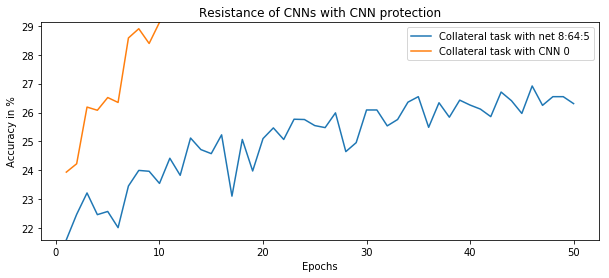

In [31]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
# ,
#    (
#        nn.Conv2d(1, 30, 4, 1),
#        nn.Conv2d(30, 100, 4),
#        nn.Linear(100 * 4 * 4, 1000),
#        nn.Linear(1000, 100),
#        nn.Linear(100, N_FONTS)
#    )
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

In [32]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.distinguisher_epochs = 10 # <-- NEW value
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [33]:
build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.800037
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.724369
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.705991
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.690245

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2036/4011 (50.76%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.701229
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.690628
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.683204
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.700539

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2102/4011 (52.41%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 0.687510
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.707055
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.701501
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.681435

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2079/4011 (51.83%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0

In [34]:
test_distinguish(model, test_dataset)

Acc 52.4 %


The following cell has been run 3 times.

In [39]:
for i in range(5): # + 5
    build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.596290
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.412281
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.417342
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.376967

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2890/4011 (72.05%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.369492
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.484819
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.491582
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.466229

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2890/4011 (72.05%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 0.570360
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.447583
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.625348
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.414034

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2786/4011 (69.46%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0


Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2933/4011 (73.12%)
Train Epoch: 8 [0/24193 (0%)]	Loss Font: 0.413924
Train Epoch: 8 [6400/24193 (26%)]	Loss Font: 0.375105
Train Epoch: 8 [12800/24193 (53%)]	Loss Font: 0.312159
Train Epoch: 8 [19200/24193 (79%)]	Loss Font: 0.694612

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2967/4011 (73.97%)
Train Epoch: 9 [0/24193 (0%)]	Loss Font: 0.335434
Train Epoch: 9 [6400/24193 (26%)]	Loss Font: 0.283693
Train Epoch: 9 [12800/24193 (53%)]	Loss Font: 0.328625
Train Epoch: 9 [19200/24193 (79%)]	Loss Font: 0.534009

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2839/4011 (70.78%)
Train Epoch: 10 [0/24193 (0%)]	Loss Font: 0.575589
Train Epoch: 10 [6400/24193 (26%)]	Loss Font: 0.387158
Train Epoch: 10 [12800/24193 (53%)]	Loss Font: 0.384934
Train Epoch: 10 [19200/24193 (79%)]	Loss Font: 0.301355

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2965/4011 (73.92%)
Traini

In [40]:
test_distinguish(model, test_dataset)

Acc 74.9 %


Accuracy is very low (57% after 5 more epochs) but this shouldn't hide the fact that we couldn't let the CNN run enough. However it shows that the task is far more complicated for the attacker. After 5 more epochs it get much higher at 70%. And after 5 more you reach 75%.

## Summary

The sabotage phase has a real influence on the ability of CL models to perform well. The longer the sabotage, the harder it is for a model to recover some utility. This applies also for distinguisher attacks.

Note: we did an extreme example with 150 epochs of sabotage and 150 of distinguisher training: we achieve only 56% for the FFN and 59% for the CNN. This confirms our impressions.

Here is the full spec for the run:

In [ ]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 20
        self.sabotage_epochs = 150
        self.new_adversary_epochs = 50
        self.distinguisher_epochs = 150
        self.lr = 0.0017
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100